# Tomato Disease Progression

### Introduction

Managing diseases and pests in greenhouses or open fields poses a significant challenge for farmers aiming to produce healthy food. If not properly addressed, these issues can devastate crops. While maintaining proper soil health is essential, farmers often resort to chemical sprays or biological pest control to protect their harvests.

Accurate identification of these problems is crucial but can be labor-intensive for farmers. Fortunately, Fermata's Croptimus technology allows for AI-assisted evaluations of crop images for faster detection and more effective management.


In this exercise we analyzed diseases detected in tomato plants by human auditors and those detected by AI. 

We will observe how these diseases progressed over the 17 week period from which the data was gathered as well as spatially across the greenhouse.

There are several figures in this notebook.  However, for a more interactive experience, please refer to the [Tableau figures linked here](https://public.tableau.com/views/Eliezer-Tomatodiseaseexercise/AI-DiseaseProgressionperWeek?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link).  There are four sheets, AI and auditor disease progression and AI and auditor disease spread over the growing area.  Please make sure to select the proper sheet using the tabs at the top.

In the time-series graphs one can hover over a particular disease and week to see the number of occurences.  In the spatial map one can see where each disease was observed as well as use the filter to either see all weeks or a specific week.

In this reports summary we will touch on the differences between superiority of AI detection versus human detection.

## Preliminary observation of data
Loading the data and seperating the data into auditor-detected and AI-detected problems

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#open the file to read a binary file and deserialize it with .load
with open('incidents_for_eliezer.pickle', 'rb') as file:
    data = pickle.load(file)

In [3]:
type(data)

list

In [4]:
first_incident = data[0]

In [5]:
#first_incident

In [6]:
print(f'Total items in the list: {len(data)}')

Total items in the list: 1


In [7]:
print(f'Total items in first item: {len(first_incident)}')

Total items in first item: 85321


This is a nested list, consisting of Auditor and AI inputs.  The incidents that were observed by auditors and those observed by AI need to be isolated.  Afterwards, the data can be flattened and analyzed.

In [8]:
# Lists to store the separated incidents
data_list = data[0]

auditor_detected = []
ai_detected = []

# Loop through the data and categorize based on 'auditor_labels'
for incident in data_list:
    if incident['auditor_labels']:
        auditor_detected.append(incident)
    else:
        ai_detected.append(incident)

# Check the count of each type
print(f"Auditor-detected incidents: {len(auditor_detected)}")
print(f"AI-detected incidents: {len(ai_detected)}")

Auditor-detected incidents: 10903
AI-detected incidents: 74418


In [9]:
#check if indicent in auditor dectected was also detected by AI
ai_missed = []
for incident in auditor_detected:
    if 'ai_labels' not in incident or len(incident['ai_labels'])==0:
        ai_missed.append(incident)
        
print(f'Auditor incidents missed by AI: {len(ai_missed)}')

Auditor incidents missed by AI: 0


In [10]:
print(len(data_list))

85321


In [11]:
len(auditor_detected)

10903

In [12]:
#auditor_detected[:10]

In [13]:
len(ai_detected)

74418

In [14]:
#ai_detected[:10]

In [15]:
percent_auditor = len(auditor_detected)/len(first_incident)
print(f'Percentage of total incidents that were detected by the auditor: {round(percent_auditor, 4)}')

percent_ai = len(ai_detected)/len(first_incident)
print(f'Percentage of total incidents that were detected by only the AI: {round(percent_ai, 4)}')

      


Percentage of total incidents that were detected by the auditor: 0.1278
Percentage of total incidents that were detected by only the AI: 0.8722


It seems that far less incidents were picked up by the human auditors.  However, on closer examination of the data we can see that the list still contains items that are by the same auditor but have multiple observations.

Looking at this data we see that the AI model stores the data much cleaner.  Each observation is paired with a diagnosis or not.  The auditor observations are good but sometimes unclear on the type of agricultural/pest damage is present.

AI was able to take more timeslices of the situation and produce more data.

## Extract Regions and Disease Diagnosis

Because the auditor data contains multiple observations and diagnosis in each entry, this code seperates it and converts it into a dataframe to allow for easier analysis.

We do the same for the AI entries.

In [16]:
#make a dataframe out of the auditor and AI detected problems

#for auditor detected problems

auditor_progression = []

for incident in auditor_detected:
    for auditor_label in incident.get('auditor_labels', []):
        for region in auditor_label.get('regions', []):
            result = region.get('result', {})
            diagnosis = result.get('Diagnosis', [])
            x_coord = incident['x']
            y_coord = incident['y']
            
            auditor_progression.append({
                'id': incident['id'],
                'created_at': incident['created_at'],
                'region': region['region'],
                'diagnosis': diagnosis,
                'x': x_coord,
                'y': y_coord
            })

# Convert to DataFrame for analysis
df_auditor = pd.DataFrame(auditor_progression)
df_auditor.head(15)

,id,created_at,region,diagnosis,x,y
0,9c0f6812-c71b-40b2-ab35-07ab7738b7ed,2024-06-20 04:43:14.425,"[1536.0, 576.0, 2048.0, 864.0]",[],-13.2,-17.3
1,db83209d-b5e6-43f3-a111-bba719dfc4f2,2024-06-20 04:48:38.059,"[1024.0, 1152.0, 1536.0, 1440.0]",[],-13.1,-15.9
2,db83209d-b5e6-43f3-a111-bba719dfc4f2,2024-06-20 04:48:38.059,"[1024.0, 576.0, 1536.0, 864.0]",[],-13.1,-15.9
3,e1d659ea-d457-4221-9b3a-38a397bc1788,2024-06-20 04:48:38.059,"[1536.0, 288.0, 2048.0, 576.0]",[],-8.8,-13.4
4,c27803f8-7952-4801-9b64-b34ceaa0cd70,2024-06-20 04:48:38.059,"[0.0, 864.0, 512.0, 1152.0]",[3],-8.9,-11.6
5,6d0291e2-04e8-4899-96a8-5ea4cd47f128,2024-06-20 04:50:48.065,"[1536.0, 576.0, 2048.0, 864.0]",[4],-23.5,-13.3
6,ee877d02-952a-4c10-9754-fc4aeda800c8,2024-06-20 04:50:48.065,"[2048.0, 576.0, 2560.0, 864.0]",[42],-9.6,-14.0
7,ee877d02-952a-4c10-9754-fc4aeda800c8,2024-06-20 04:50:48.065,"[2048.0, 576.0, 2560.0, 864.0]",[13],-9.6,-14.0
8,43657c4c-8a89-45a3-98c6-a5e44e9547a0,2024-06-20 04:51:10.215,"[2048.0, 576.0, 2560.0, 864.0]",[],-18.0,-12.8
9,43657c4c-8a89-45a3-98c6-a5e44e9547a0,2024-06-20 04:51:10.215,"[1536.0, 576.0, 2048.0, 864.0]",[13],-18.0,-12.8


Checking the data we see that it was successful.  For example, 'id': '43657c4c-8a89-45a3-98c6-a5e44e9547a0' had three sets of regions recorded in one entry.  Here in this dataframe they are separated into three different rows, with only one being diagnosed.

In [17]:
df_auditor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42046 entries, 0 to 42045
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          42046 non-null  object        
 1   created_at  42046 non-null  datetime64[ns]
 2   region      42046 non-null  object        
 3   diagnosis   42046 non-null  object        
 4   x           42046 non-null  float64       
 5   y           42046 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 1.9+ MB


In [18]:
#for AI-detected problems:

ai_progression = []

for incident in ai_detected:
    for ai_label in incident.get('ai_labels', []):
        for region in ai_label.get('regions', []):
            result = region.get('result', {})
            diagnosis = result.get('Diagnosis', [])            
            x_coord = incident['x']
            y_coord = incident['y']
            
            ai_progression.append({
                'id': incident['id'],
                'created_at': incident['created_at'],
                'region': region['region'],
                'diagnosis': diagnosis,                
                'x': x_coord,
                'y': y_coord
            })

# Convert to DataFrame for analysis
df_ai = pd.DataFrame(ai_progression)
df_ai.head()

,id,created_at,region,diagnosis,x,y
0,a9ca0f3a-81d3-47a6-b97a-2552cd7a8554,2024-06-20 04:42:38.263,"[1024.0, 288.0, 1536.0, 576.0]",[4],-18.1,-17.4
1,51c89053-26ae-4e95-a516-f214d47d53d6,2024-06-20 04:48:38.059,"[1536.0, 0.0, 2048.0, 288.0]",[2],-9.5,-14.7
2,51c89053-26ae-4e95-a516-f214d47d53d6,2024-06-20 04:48:38.059,"[1536.0, 0.0, 2048.0, 288.0]",[3],-9.5,-14.7
3,51c89053-26ae-4e95-a516-f214d47d53d6,2024-06-20 04:48:38.059,"[1536.0, 0.0, 2048.0, 288.0]",[45],-9.5,-14.7
4,843737b5-7051-41cb-9851-6918e39eaa1f,2024-06-20 04:50:48.065,"[1536.0, 864.0, 2048.0, 1152.0]",[51],-6.0,-6.1


In [19]:
df_ai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13532 entries, 0 to 13531
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          13532 non-null  object        
 1   created_at  13532 non-null  datetime64[ns]
 2   region      13532 non-null  object        
 3   diagnosis   13532 non-null  object        
 4   x           13532 non-null  float64       
 5   y           13532 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 634.4+ KB


The AI dataframe only contains 13532 entries.  This is only 18% of the total AI entries from the initial list.  We can see in the dataframe that all of these entries contain diagnosis.

In [20]:
#check if any id's appear twice in the lists

common_ids = pd.merge(df_auditor[['id']], df_ai[['id']], on='id')

print(common_ids)


Empty DataFrame
Columns: [id]
Index: []


In [21]:
df_data = pd.DataFrame(data_list)
df_data.head()

,id,created_at,auditor_labels,ai_labels,x,y
0,5efaf80f-7945-4a28-9e2f-9c624d3fc19d,2024-06-20 04:42:38.263,[],"[{'model_info': {'model_version': '4', 'name':...",-18.0,-20.2
1,ef26e3bb-e13a-4ccf-a332-295012081237,2024-06-20 04:42:38.263,[],"[{'model_info': {'model_version': '4', 'name':...",-23.1,-22.4
2,a94896df-843e-4457-9cc7-68fa6396b124,2024-06-20 04:42:38.263,[],"[{'model_info': {'model_version': '4', 'name':...",-23.3,-10.0
3,ad0a6cf0-aa90-4b66-8728-1617edd01928,2024-06-20 04:42:38.263,[],"[{'model_info': {'model_version': '4', 'name':...",-17.1,-19.1
4,8fdfb51e-b947-40d4-a0cd-b0400ea90118,2024-06-20 04:42:38.263,[],"[{'model_info': {'model_version': '4', 'name':...",-18.0,-16.1


In [22]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85321 entries, 0 to 85320
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              85321 non-null  object        
 1   created_at      85321 non-null  datetime64[ns]
 2   auditor_labels  85321 non-null  object        
 3   ai_labels       85321 non-null  object        
 4   x               85321 non-null  float64       
 5   y               85321 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 3.9+ MB


No duplicates, no null values.

In [23]:
df_auditor['diagnosis'].value_counts()

[]          28631
[13]         9499
[4]          1658
[21]         1292
[1]           241
[3]           235
[45]          122
[21, 13]       75
[16]           56
[42]           46
[12]           33
[55]           32
[44]           31
[4, 13]        22
[51]           18
[15]           11
[5]            10
[2]            10
[13, 3]         5
[21, 4]         4
[20]            3
[1, 13]         2
[55, 4]         2
[44, 4]         1
[1, 21]         1
[39]            1
[13, 16]        1
[4, 12]         1
[15, 4]         1
[3, 45]         1
[21, 1]         1
Name: diagnosis, dtype: int64

In [24]:
28653/df_auditor['diagnosis'].value_counts().sum()

0.6814679160918994

In [25]:
df_ai['diagnosis'].value_counts()

[21]    3341
[42]    3181
[13]    1537
[4]     1392
[3]     1145
[45]     748
[44]     714
[51]     495
[2]      402
[1]      329
[15]     196
[5]       52
Name: diagnosis, dtype: int64

In [26]:
ai_d_counts = df_ai['diagnosis'].value_counts()
ai_d_per = df_ai['diagnosis'].value_counts(normalize=True)
pd.concat([ai_d_counts,ai_d_per], axis=1, keys=['count', 'percentage'])

,count,percentage
[21],3341,0.246896
[42],3181,0.235072
[13],1537,0.113583
[4],1392,0.102867
[3],1145,0.084614
[45],748,0.055276
[44],714,0.052764
[51],495,0.036580
[2],402,0.029707
[1],329,0.024313


In [27]:
df_auditor.shape

(42046, 6)

In [28]:
df_ai.shape

(13532, 6)

### Discrepancies among human vs ai diagnosis

68% of the observations by human auditors were not diagnosed as a particular disease.  Of the remaining diagnosis, 71% were diagnosed at '13' and 12% as '4' and less than 10% at '21'.

On the contrary, because the AI dataframe contains only the observations by the AI audit that were flagged as a problem, it contains diagnoses for all events while disregarding those that were 'clean'.  25% of diseases were diagnosed as disease '21', 23.5% were diagosed as '41' and 11% were diagnosed as '13'.

Additionally, both the human and the AI sometimes diagosed the same spot as multiple diseases.  This seems problematic but is possible because an affected plant has a lower immune system and can then be susceptible to multiple attacks on a single leaf.  AI seems to be more effective at parsing these individual problems.

## Disease progression over the time period

We use matplot lib to graph the frequency of each diagnosis per week so see the disease progression in the field.

In [29]:
df_auditor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42046 entries, 0 to 42045
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          42046 non-null  object        
 1   created_at  42046 non-null  datetime64[ns]
 2   region      42046 non-null  object        
 3   diagnosis   42046 non-null  object        
 4   x           42046 non-null  float64       
 5   y           42046 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 1.9+ MB


    year_week diagnosis  count
0     2024-24         1      1
1     2024-24        13     19
2     2024-24        21      1
3     2024-24         3     48
4     2024-24         4      3
..        ...       ...    ...
171   2024-40         1      2
172   2024-40        12      1
173   2024-40        13    269
174   2024-40        21     50
175   2024-40         4     52

[176 rows x 3 columns]


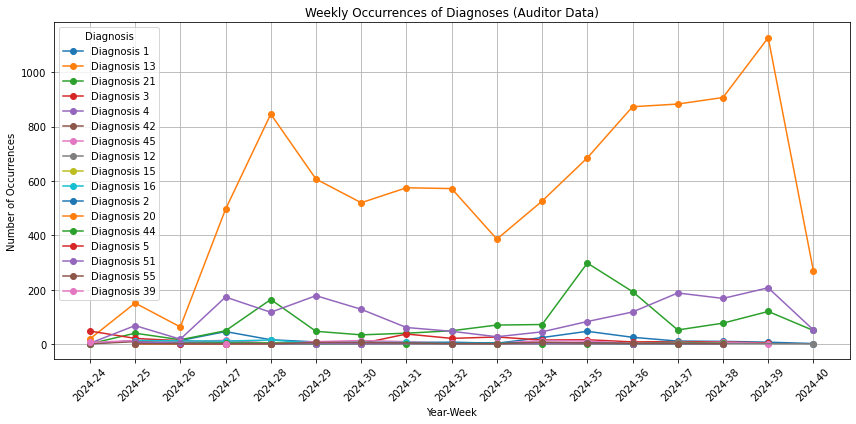

In [30]:
#Plot the disease observations to see the frequency and prevalence of each diagosis type over the time period.



# Create a new column for year and week
df_auditor['year_week'] = df_auditor['created_at'].dt.strftime('%Y-%U')

# Flatten the diagnosis field to include only the first response
df_auditor['diagnosis'] = df_auditor['diagnosis'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Group by 'year_week' and 'diagnosis' and count the occurrences
weekly_counts_auditor = df_auditor.groupby(['year_week', 'diagnosis']).size().reset_index(name='count')

print(weekly_counts_auditor)

# Set up the plot
plt.figure(figsize=(12, 6))

# Plotting each diagnosis with different colors
for diagnosis in weekly_counts_auditor['diagnosis'].unique():
    subset = weekly_counts_auditor[weekly_counts_auditor['diagnosis'] == diagnosis]
    plt.plot(subset['year_week'], subset['count'], marker='o', label=f'Diagnosis {diagnosis}')

# Customize the plot
plt.title('Weekly Occurrences of Diagnoses (Auditor Data)')
plt.xlabel('Year-Week')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.legend(title='Diagnosis')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


From this graph we can see that the auditor data diagnosed disease '13' as the most prevalant problem during the time period with spikes at week 28 and week 39.  Disease 21 and disease 4 also had a (smaller) spike around week 28 and again a slight increase around weeks 35-39.

In [31]:
df_ai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13532 entries, 0 to 13531
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          13532 non-null  object        
 1   created_at  13532 non-null  datetime64[ns]
 2   region      13532 non-null  object        
 3   diagnosis   13532 non-null  object        
 4   x           13532 non-null  float64       
 5   y           13532 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 634.4+ KB


    year_week diagnosis  count
0     2024-24         1      6
1     2024-24        13     32
2     2024-24        15      3
3     2024-24         2      2
4     2024-24        21     14
..        ...       ...    ...
184   2024-40         3     73
185   2024-40         4    164
186   2024-40        42      3
187   2024-40        44      6
188   2024-40        51     10

[189 rows x 3 columns]


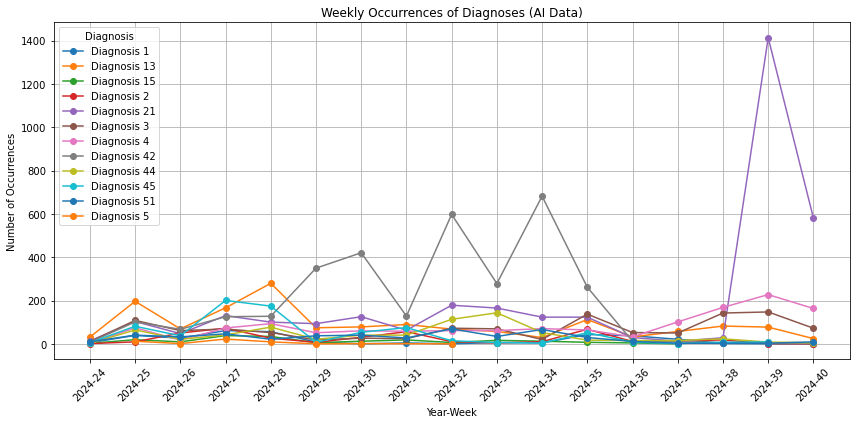

In [32]:
# Create a new column for year and week
df_ai['year_week'] = df_ai['created_at'].dt.strftime('%Y-%U')

# Flatten the diagnosis field to include only the first response
df_ai['diagnosis'] = df_ai['diagnosis'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Group by 'year_week' and 'diagnosis' and count the occurrences
weekly_counts_ai = df_ai.groupby(['year_week', 'diagnosis']).size().reset_index(name='count')

print(weekly_counts_ai)

# Set up the plot
plt.figure(figsize=(12, 6))

# Plotting each diagnosis with different colors
for diagnosis in weekly_counts_ai['diagnosis'].unique():
    subset = weekly_counts_ai[weekly_counts_ai['diagnosis'] == diagnosis]
    plt.plot(subset['year_week'], subset['count'], marker='o', label=f'Diagnosis {diagnosis}')

# Customize the plot
plt.title('Weekly Occurrences of Diagnoses (AI Data)')
plt.xlabel('Year-Week')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.legend(title='Diagnosis')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


With the visual for the AI data we can see that the model picked up a slight increase in disease 13 around week 28, consistant with the human auditor data but then dropped down again.  

At week 29, the model diagnosed an increase in disease 42 for the next six weeks until the numbers dropped down.  This disease was rarely detected in the human auditors.

The highest detection of disease occured in the last two weeks with a very large observation of disease 21.  This disease was identified also during the course of the data by auditors but may have mistaken this large jump at the end with a different disease (namely 13).

## Spatial Map: Spread of the disease in the growing area

Here we make use of a spacial map (a scatterplot from seaborn) to see exactly where in the field the problem areas are.

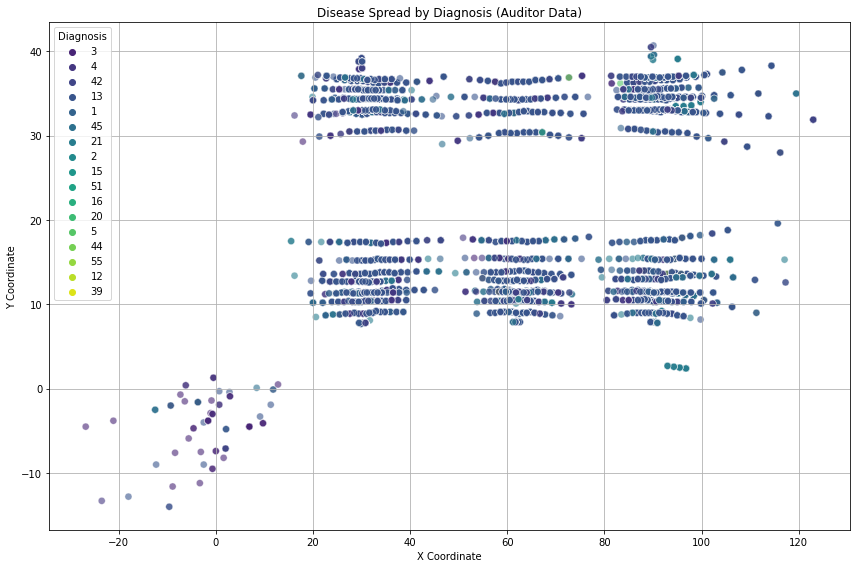

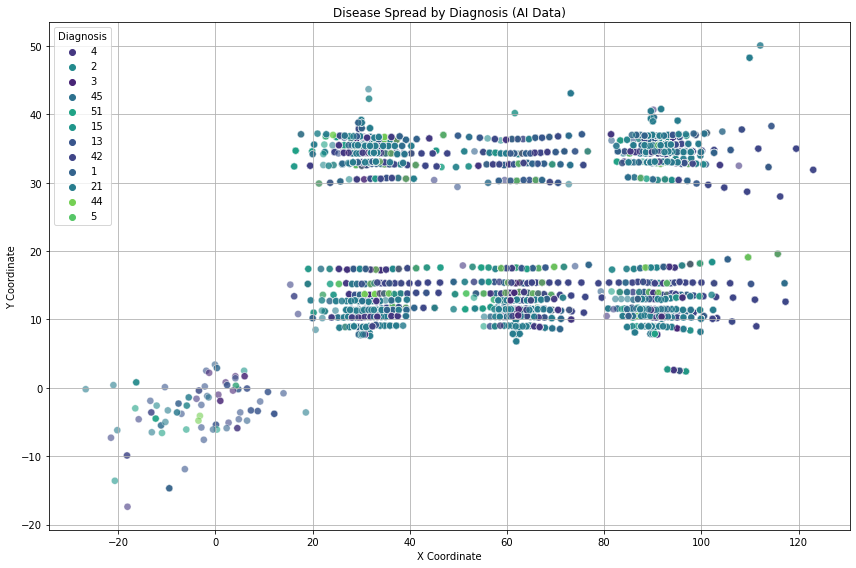

In [33]:
import seaborn as sns

# Get unique diagnoses from both DataFrames
unique_diagnoses = pd.Series(pd.concat([df_auditor['diagnosis'], df_ai['diagnosis']]).unique())

# Create a color palette based on the number of unique diagnoses
palette = sns.color_palette("viridis", n_colors=len(unique_diagnoses))

# Create a mapping from diagnosis to color
diagnosis_color_map = dict(zip(unique_diagnoses, palette))

def plot_density_spread_with_diagnosis(df, title):
    plt.figure(figsize=(12, 8))
    
    # Create a scatter plot with colors based on the shared palette
    sns.scatterplot(data=df, x='x', y='y', hue='diagnosis', palette=diagnosis_color_map, alpha=0.6, s=50)

    # Customize the plot
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid()
    plt.legend(title='Diagnosis')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plot for Auditor Data
plot_density_spread_with_diagnosis(df_auditor, title='Disease Spread by Diagnosis (Auditor Data)')

# Plot for AI Data
plot_density_spread_with_diagnosis(df_ai, title='Disease Spread by Diagnosis (AI Data)')


In [34]:
df_auditor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42046 entries, 0 to 42045
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          42046 non-null  object        
 1   created_at  42046 non-null  datetime64[ns]
 2   region      42046 non-null  object        
 3   diagnosis   13415 non-null  object        
 4   x           42046 non-null  float64       
 5   y           42046 non-null  float64       
 6   year_week   42046 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 2.2+ MB


The above graphs are good but we would like to see progression over time as well.  We get a small picture of this by making two separate plots, one for the first half of the observations and one for the second.

In [35]:
median_date = df_auditor['created_at'].median()
median_date

Timestamp('2024-08-26 03:16:26.224000')

In [36]:
#split df into two sets to see progression
df_auditor_1 = df_auditor[df_auditor['created_at']< median_date]
df_auditor_1.info()
#split df into two sets to see progression
df_auditor_1 = df_auditor[df_auditor['created_at']< median_date]
df_auditor_1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21020 entries, 0 to 23503
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          21020 non-null  object        
 1   created_at  21020 non-null  datetime64[ns]
 2   region      21020 non-null  object        
 3   diagnosis   6290 non-null   object        
 4   x           21020 non-null  float64       
 5   y           21020 non-null  float64       
 6   year_week   21020 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21020 entries, 0 to 23503
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          21020 non-null  object        
 1   created_at  21020 non-null  datetime64[ns]
 2   region      21020 non-null  object        
 3   diagnosis   6290 non-null   object  

In [37]:
df_auditor_2 = df_auditor[df_auditor['created_at']>= median_date]
df_auditor_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21026 entries, 20993 to 42045
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          21026 non-null  object        
 1   created_at  21026 non-null  datetime64[ns]
 2   region      21026 non-null  object        
 3   diagnosis   7125 non-null   object        
 4   x           21026 non-null  float64       
 5   y           21026 non-null  float64       
 6   year_week   21026 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 1.3+ MB


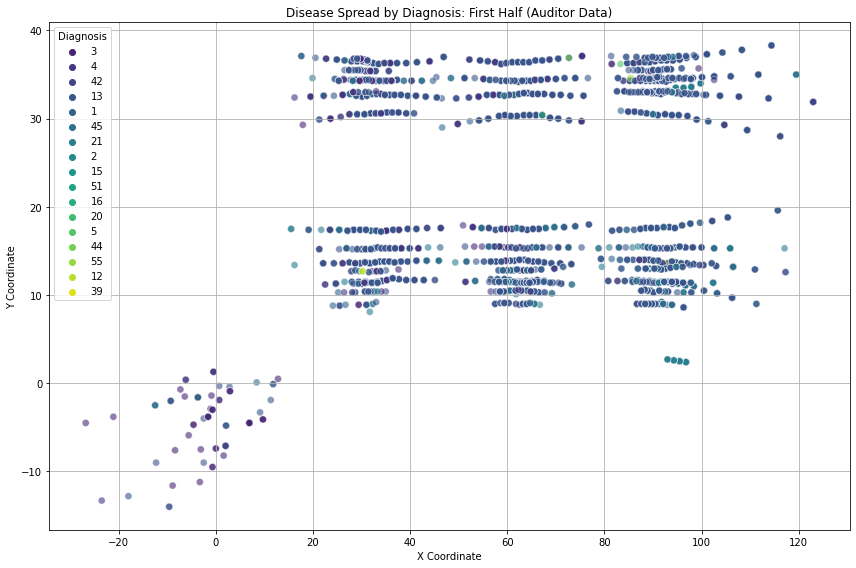

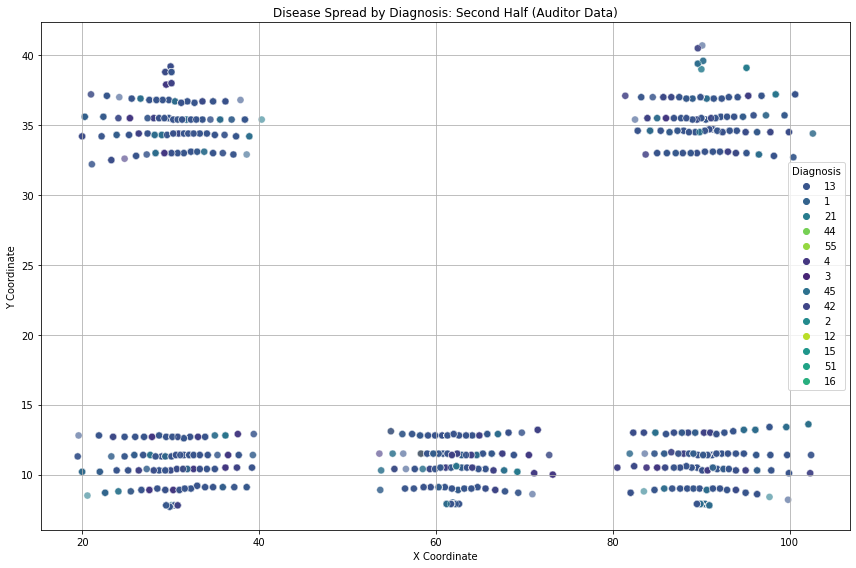

In [38]:
#plot
plot_density_spread_with_diagnosis(df_auditor_1, title='Disease Spread by Diagnosis: First Half (Auditor Data)')
plot_density_spread_with_diagnosis(df_auditor_2, title='Disease Spread by Diagnosis: Second Half (Auditor Data)')

In [39]:
#splitting ai observation into two different sets

In [40]:
median_date_ai = df_ai['created_at'].median()
median_date_ai

Timestamp('2024-08-17 00:55:09.404999936')

In [41]:
#split df into two sets to see progression
df_ai_1 = df_ai[df_ai['created_at']< median_date_ai]
df_ai_1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6762 entries, 0 to 7051
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          6762 non-null   object        
 1   created_at  6762 non-null   datetime64[ns]
 2   region      6762 non-null   object        
 3   diagnosis   6762 non-null   object        
 4   x           6762 non-null   float64       
 5   y           6762 non-null   float64       
 6   year_week   6762 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 422.6+ KB


In [42]:
df_ai_2 = df_ai[df_ai['created_at']>= median_date_ai]
df_ai_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6770 entries, 5854 to 13531
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          6770 non-null   object        
 1   created_at  6770 non-null   datetime64[ns]
 2   region      6770 non-null   object        
 3   diagnosis   6770 non-null   object        
 4   x           6770 non-null   float64       
 5   y           6770 non-null   float64       
 6   year_week   6770 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 423.1+ KB


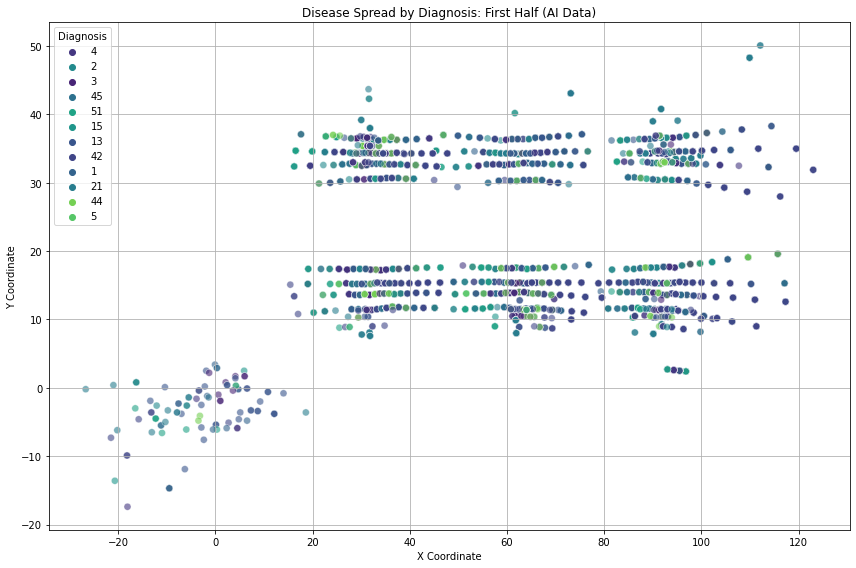

In [43]:
#plot
plot_density_spread_with_diagnosis(df_ai_1, title='Disease Spread by Diagnosis: First Half (AI Data)')

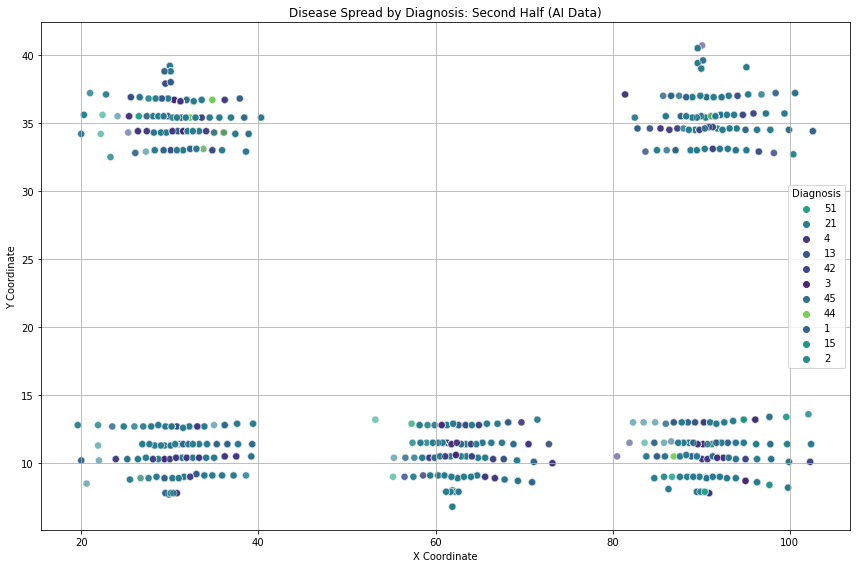

In [44]:
plot_density_spread_with_diagnosis(df_ai_2, title='Disease Spread by Diagnosis: Second Half (AI Data)')

In these spatial maps we can see the spread of the disease across the growing area.  The auditor and AI observations differ in disease identification but are similar in location.

There is some observations in the bottom left quadrant, around (0,0).  This could be the source of the introduction of contaminants or pests that could have led to other problems.

The main problem areas are concentrated in six clumps that appear to be split up into two rows of three each.  These could be single plants or groups of affected plants.  

When we split up the data into two time periods we see that the instances were curtailed slightly during the second time period.  The outlying observations extended to the left and right of each clump were decreased.  In fact, the problem area located around (60,35) is non existent during the second half of the data.  This is seen in both the auditor and the AI observations.  The problem was either remedied or we are seeing a lack (death/removal) of problem plants.

The farmer was able to identify and isolate the problem with the help of smart identification and introduced methods to curtail its proliferation.  

## Tableau Figures

In [45]:
#export databases to make a dashboard

#auditor
df_auditor.to_csv('df_auditor.csv')

#ai
df_ai.to_csv('df_ai.csv')

There are several figures in this notebook.  However, for a more interactive experience, please refer to the [Tableau figures linked here](https://public.tableau.com/views/Eliezer-Tomatodiseaseexercise/AI-DiseaseProgressionperWeek?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link).  There are four sheets, AI and auditor disease progression and AI and auditor disease spread over the growing area.  Please make sure to select the proper sheet using the tabs at the top.

In the time-series graphs one can hover over a particular disease and week to see the number of occurances.  In the spatial map one can see where each disease was observed as well as use the filter to either see all weeks or a specific week.

## Summary

### Disease Prevalence, Progression and Distribution

#### Prevalence

Among the human diagnosed cases, 71% were identified as disease '13', 12% as '4', and less than 10% as '21'.

In contrast, the AI data showed 25% of diagnoses as disease '21', 23.5% as '41', and 11% as '13'.

#### Progression

The human auditor data showed disease '13' as the most prevalent problem throughout the 17-week period, with significant spikes at weeks 28 and 39. Diseases '21' and '4' also saw a smaller spike around week 28, followed by a slight increase again between weeks 35 and 39. This suggests a recurring issue with these diseases during certain periods of the crop cycle.

The AI data confirmed a slight increase in disease '13' around week 28, aligning with the human auditor data. However, after that initial rise, disease '13' detections by the AI dropped off. By week 29, the AI system began detecting a surge in disease '42', which persisted for six weeks before dropping again. Notably, disease '42' was rarely detected by human auditors, indicating that AI may have picked up an issue that humans largely missed.

The most significant AI detection occurred during the last two weeks of the data, where there was a substantial increase in disease '21'. Although human auditors also identified this disease earlier, they may have misinterpreted the final large spike as disease '13', showing discrepancies in disease identification between AI and human assessments.

#### Distribution

Disease clusters were concentrated in six distinct groups, split into two rows of three, indicating potentially affected plants or groups.

The bottom-left quadrant (around coordinates 0,0) showed notable contamination or pest introduction, potentially sparking the spread of disease.

Over time, the spread of disease was curtailed, particularly in areas like (60,35), where problems disappeared in the second half of the dataset, suggesting successful intervention or plant removal.

Using the [tableau dashboards and the slider filter](https://public.tableau.com/views/Eliezer-Tomatodiseaseexercise/AI-DiseaseLocation?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link), one can easily see which disease issues were less of a problem as the weeks progressed.  However, while most diseases dropped out after 8 September 2024 (week 36), there was a rise in disease 21 afterward.

### Observations on AI vs Human Detection

Even though the auditors diagnosed 32% of observations while the AI model only diagnosed 18% of observed events, AI provided cleaner, more structured data, with a clear diagnoses attached to each observation, whereas human auditors' notes were occasionally unclear or less detailed when describing the specific types of agricultural or pest damage.

AI also captured more timeslices.  This led to a lower diagnosis rate but allowed richer insights into the problem's evolution byoffering a more detailed temporal progression of the disease spread.

Both human auditors and AI occasionally diagnosed the same spot with multiple diseases, but AI seemed more adept at distinguishing between these different issues, leading to more precise diagnoses.

This can be crucial since a weakened plant can suffer from multiple simultaneous diseases or pests.  Even if the models see an increase in a particular pest in the greenhouse, attention also needs to be directed to plant health are precise locations.

### Insights

The progression patterns suggest that early intervention, informed by AI and human detections, helped curtail disease spread, as evidenced by the reduced problems in the second half of the dataset.

AI's ability to provide more comprehensive coverage and more frequent observations likely played a role in helping the farmer isolate and mitigate the disease, leading to improved outcomes.